In [1]:
import math
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from pykalman import KalmanFilter

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
arima_train_split = 0.3
arima_model_order = (0,1,3)

In [4]:
def read_file(filename, node_id, coord = "x"):
    with open(filename) as f:
        if coord == "x":
            lines = [float(i.split()[5]) for i in f.readlines() if
                     "node_({})".format(node_id) in i
                    and "setdest" in i]
        elif coord == "y":
            lines = [float(i.split()[6]) for i in f.readlines() if
                     "node_({})".format(node_id) in i
                    and "setdest" in i]
        else:
            raise ValueError("invalid coordinate")
        return lines

In [5]:
def arima_predict(train, test, model_param=(2,2,0)):
#         print(model)
        predictions = []

        for i, v in enumerate(test):
#             model train
            model = ARIMA(train, order=model_param)
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
#             print(model_fit.summary())
            yhat = output[0]
            predictions.append(yhat)
#             obs = v
            train.append(v)
        return predictions

In [6]:
def arima(model_param=(0,2,0)):

    mse = []

#     for i in range (number_of_users):
    observations_x = read_file("./LusT.tcl", 1, "x")
    observations_y = read_file("./LusT.tcl", 1, "y")

    size_x = int(len(observations_x) * arima_train_split)
    train_x, test_x = observations_x[0:size_x], observations_x[size_x:len(observations_x)]
#         history_x = [x for x in train_x]

    size_y = int(len(observations_y) * arima_train_split)
    train_y, test_y = observations_y[0:size_y], observations_y[size_y:len(observations_y)]
#         history_y = [x for x in train_y]

    predictions_x = arima_predict(train_x, test_x, model_param=model_param)
    predictions_y = arima_predict(train_y, test_y, model_param=model_param)

    error_x = math.sqrt(mean_squared_error(test_x, predictions_x))
    error_y = math.sqrt(mean_squared_error(test_y, predictions_y))
    # print('Test MSE: %.3f' % error)
    return predictions_x, predictions_y, test_x, test_y, error_x, error_y

In [7]:
def kalman():
#     error = []
#     for i in range (number_of_users):
    observations_x = read_file("./LusT.tcl", 1, "x")
    observations_y = read_file("./LusT.tcl", 1, "y")

    kf = KalmanFilter(transition_matrices=np.array([[1, 1], [0, 1]]),
                      transition_covariance=0.01 * np.eye(2))
    states_pred_x = kf.em(observations_x).smooth(observations_x)[0]
    states_pred_y = kf.em(observations_y).smooth(observations_y)[0]

    mse_x = math.sqrt(sum((states_pred_x[:, 0] - observations_x)**2) / len(observations_x))
    mse_y = math.sqrt(sum((states_pred_y[:, 0] - observations_y)**2) / len(observations_y))

    # return (states_pred_x[:,0], states_pred_y[:,0])
#     error.append(mse)
    return states_pred_x, states_pred_x, observations_x, observations_y, mse_x, mse_y

In [8]:
def grid_search():
    for pt in range(6):
        for d in range(3):
            for ma in range(6):
                try:
                    predictions_x, predictions_y, test_x, test_y, error_x, error_y = arima(model_param=(pt, d, ma))
                    print(f"model ({pt}, {d}, {ma}) error {(error_x + error_y) / 2}")
                except:
                    print(f"model ({pt}, {d}, {ma}) error")
# grid_search()

In [9]:
ar_before = datetime.now()
predictions_x, predictions_y, test_x, test_y, error_x, error_y = arima()
ar_after = datetime.now()

kf_before = datetime.now()
states_pred_x, states_pred_x, observations_x, observations_y, mse_x, mse_y = kalman()
kf_after = datetime.now()

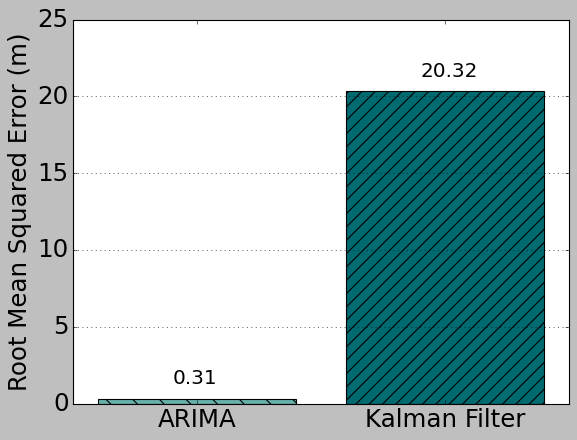

In [63]:
data = [np.mean([error_x, error_y]), np.mean([mse_x, mse_y])]

colors = ['#68b0ab', '#006a71']
hatches = ['\\', '//']

plt.style.use("classic")
plt.figure()
plt.grid(axis="y")
plt.ylabel("Root Mean Squared Error (m)", fontsize=22)
plt.yticks(fontsize=22)
plt.xticks(np.arange(2), ["ARIMA", "Kalman Filter"], fontsize=22)
bars = plt.bar(np.arange(2), data)
plt.xlim(-0.5, 1.5)

for bar, color, hatch in zip(bars, colors, hatches):
    bar.set_facecolor(color)
    bar.set_hatch(hatch)
    bar.set_edgecolor("#000")
    
for i, v in enumerate(data):
    v = np.round(v * 100) / 100
    plt.text(i - 0.1, v + 1, str(v), color='black', fontsize=18)
    
plt.savefig("rmse.pdf", bbox_inches="tight")


# plt.figure()
# plt.scatter([predictions_x, predictions_y], [test_x, test_y])

# plt.figure()
# plt.scatter([states_pred_x, states_pred_x], [observations_x, observations_y])

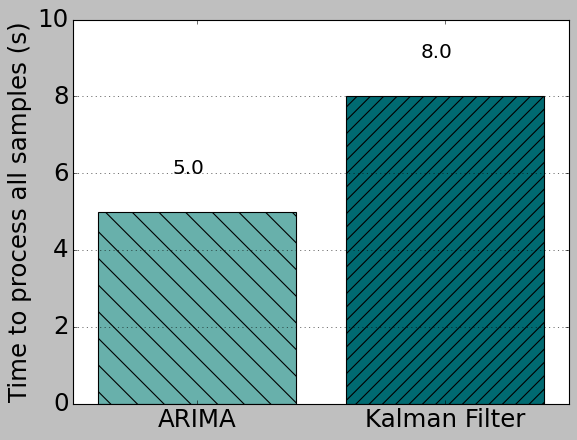

In [62]:
data = [(ar_after - ar_before).seconds, (kf_after - kf_before).seconds]

colors = ['#68b0ab', '#006a71']
hatches = ['\\', '//']

plt.style.use("classic")
plt.figure()
plt.grid(axis="y")
plt.ylabel("Time to process all samples (s)", fontsize=22)
plt.yticks(fontsize=22)
plt.xticks(np.arange(2), ["ARIMA", "Kalman Filter"], fontsize=22)
bars = plt.bar(np.arange(2), data)
plt.xlim(-0.5, 1.5)
plt.ylim(0, 10)

for bar, color, hatch in zip(bars, colors, hatches):
    bar.set_facecolor(color)
    bar.set_hatch(hatch)
    bar.set_edgecolor("#000")
    
for i, v in enumerate(data):
    v = np.round(v * 100) / 100
    plt.text(i - 0.1, v + 1, str(v), color='black', fontsize=18)
    
plt.savefig("pred_time.pdf", bbox_inches="tight")


# plt.figure()
# plt.scatter([predictions_x, predictions_y], [test_x, test_y])

# plt.figure()
# plt.scatter([states_pred_x, states_pred_x], [observations_x, observations_y])